In [1]:
# Breast Cancer prediction from Ultrasound images
## CNN 2 layers on binary mask and extracted ROI

In [2]:
# # import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
#callbacks

keras_callbacks   = [
      EarlyStopping(monitor='accuracy', patience=5, mode='max', min_delta=0.0001),
      ModelCheckpoint('./output', monitor='val_loss', save_best_only=True, mode='min')
]

# 3 layer CNN 3 layer neural network

In [4]:
def create_CNN():   
    # Initialising the CNN
    tumor_classifier = Sequential()

    # Convolution
    tumor_classifier.add(Conv2D(64, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))

    # Pooling
    tumor_classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a second convolutional layer
    tumor_classifier.add(Conv2D(64, (3, 3), activation = 'relu'))

    tumor_classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a third convolutional layer
    tumor_classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

    tumor_classifier.add(MaxPooling2D(pool_size = (2, 2)))


    # Flattening
    tumor_classifier.add(Flatten())

    # CNN network
    tumor_classifier.add(Dense(units = 1024, activation = 'relu'))
    tumor_classifier.add(Dense(units = 512, activation = 'relu'))
    tumor_classifier.add(Dense(units = 258, activation = 'relu'))
    tumor_classifier.add(Dense(units = 2, activation = 'sigmoid'))

    # Compiling the CNN
    tumor_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','AUC'])
    return(tumor_classifier)

In [5]:
# load dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_data(train_dir,test_dir):

    train_datagen = ImageDataGenerator(rescale = 1/255.,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale = 1/255.)

    train_set = train_datagen.flow_from_directory(train_dir,
                                                     target_size = (256, 256),
                                                     batch_size = 5,
                                                     class_mode = 'categorical',
                                                     color_mode='grayscale',
                                                     shuffle=True)

    test_set = test_datagen.flow_from_directory(test_dir,
                                                target_size = (256, 256),
                                                batch_size = 5,
                                                class_mode = 'categorical',
                                                color_mode='grayscale',
                                                shuffle=True)
    return(train_set,test_set)


In [6]:
import glob
train_sample_size = len(glob.glob('US_DL_mask/Train/*/*.png'))
test_sample_size = len(glob.glob('US_DL_mask/Test/*/*.png'))
train_sample_size
test_sample_size

462

185

In [22]:
batch_size=10
tumor_classifier=create_CNN()

train_set,test_set = prepare_data('US_DL_mask/Train/','US_DL_mask/Test/')

#fit model
tumor_classifier.fit_generator(train_set,
                         steps_per_epoch = train_sample_size//batch_size,
                         epochs = 30,
                         validation_data = test_set,
                         validation_steps = test_sample_size//batch_size,
                               callbacks=keras_callbacks)

Found 462 images belonging to 2 classes.
Found 185 images belonging to 2 classes.
Epoch 1/30
46/46 [==============================] - 46s 976ms/step - loss: 0.6990 - accuracy: 0.5883 - auc: 0.5723 - val_loss: 0.6202 - val_accuracy: 0.6667 - val_auc: 0.7447
INFO:tensorflow:Assets written to: ./output/assets
Epoch 2/30
46/46 [==============================] - 45s 967ms/step - loss: 0.6060 - accuracy: 0.6908 - auc: 0.7469 - val_loss: 0.6142 - val_accuracy: 0.7778 - val_auc: 0.8025
INFO:tensorflow:Assets written to: ./output/assets
Epoch 3/30
46/46 [==============================] - 51s 1s/step - loss: 0.5710 - accuracy: 0.7680 - auc: 0.8208 - val_loss: 0.6095 - val_accuracy: 0.7222 - val_auc: 0.7654
INFO:tensorflow:Assets written to: ./output/assets
Epoch 4/30
46/46 [==============================] - 50s 1s/step - loss: 0.5141 - accuracy: 0.7412 - auc: 0.8272 - val_loss: 0.6425 - val_accuracy: 0.6778 - val_auc: 0.7283
Epoch 5/30
46/46 [==============================] - 63s 1s/step - loss:

In [29]:
#save model
tumor_classifier.save('CNN2L_US_mask_BC.h5') # creates a HDF5 file ‘my_model.h5’

In [53]:
#predict
from tensorflow.keras.models import load_model
mymodel1 = load_model('CNN2L_US_mask_BC.h5')
predictions = mymodel1.predict_generator(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [10]:
#preds = tumor_classifier.predict(test_set)

In [54]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys()) 
class_labels[::-1]
class_labels

['malignant', 'benign']

['benign', 'malignant']

              precision    recall  f1-score   support

      benign       0.70      0.73      0.71       124
   malignant       0.39      0.36      0.38        61

    accuracy                           0.61       185
   macro avg       0.55      0.54      0.54       185
weighted avg       0.60      0.61      0.60       185



<Figure size 600x600 with 0 Axes>

Text(16.44444444444444, 0.5, 'True Classes')

Text(0.5, 16.444444444444446, 'Predicted Classes')

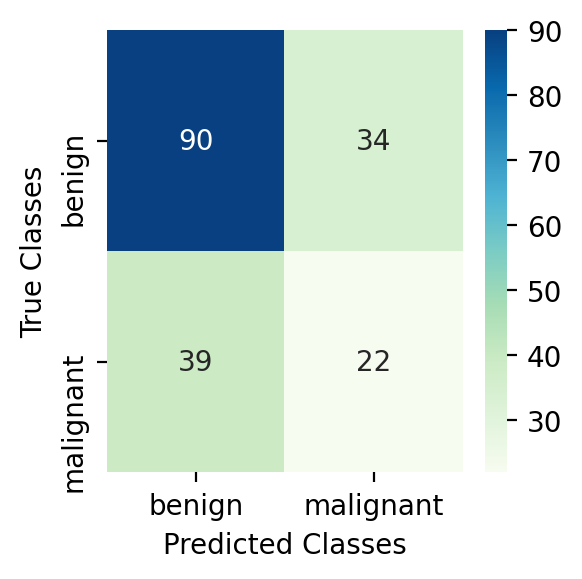

In [55]:

from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 
plt.figure(figsize=(3,3),dpi=200)
sb.heatmap(confusion_matrix(true_classes, predicted_classes),annot=True,cmap='GnBu',xticklabels=class_labels,
           yticklabels=class_labels)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.tight_layout()
plt.savefig('CM_US_CNN_mask.png')
plt.show()

In [33]:
#identify correct and wrong predictions per image
df_pred=pd.DataFrame(columns=['Image','Actual','Predicted'])
df_pred['Image']=test_set.filenames
df_pred['Actual']=test_set.classes
df_pred['Predicted']=predicted_classes
rep_dict={v:k for k, v in test_set.class_indices.items()}
df_pred.Actual.replace(rep_dict,inplace=True)
df_pred.Predicted.replace(rep_dict,inplace=True)
df_pred.head()

,Image,Actual,Predicted
0,benign/benign (1)_mask.png,benign,benign
1,benign/benign (106)_mask.png,benign,malignant
2,benign/benign (107)_mask.png,benign,benign
3,benign/benign (110)_mask.png,benign,benign
4,benign/benign (111)_mask.png,benign,benign


(1, 256, 256, 1)
{'benign': 0, 'malignant': 1}
The test image is belongs to the class:  1.0


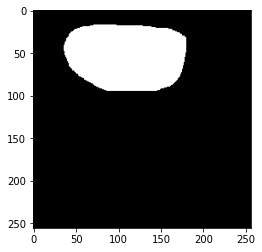

In [35]:
#model example prediction

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('US_DL_mask/Test/benign/benign (110)_mask.png', target_size = (256, 256),grayscale=True)
plt.imshow(test_image,cmap='gray')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
print(test_image.shape)
print(train_set.class_indices)
result = mymodel.predict(test_image)
print('The test image is belongs to the class: ',result[0][0])

(1, 256, 256, 1)
{'benign': 0, 'malignant': 1}
The test image is belongs to the class:  1.0


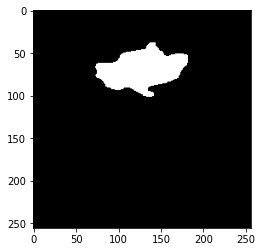

In [36]:
#malignant example
test_image = image.load_img('US_DL_mask/Test/malignant/malignant (100)_mask.png', target_size = (256, 256),grayscale=True)
plt.imshow(test_image,cmap='gray')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
print(test_image.shape)
print(train_set.class_indices)
result = mymodel.predict(test_image)
print('The test image is belongs to the class: ',result[0][0])

# Same 3 layer CNN on extracted ROI 

In [37]:
#same cnn call function
model_ROI = create_CNN()

batch_size=5


train_set,test_set = prepare_data('US_DL_roi/Train/','US_DL_roi/Test/')

#fit model
model_ROI.fit_generator(train_set,
                         steps_per_epoch = train_sample_size//batch_size,
                         epochs = 30,
                         validation_data = test_set,
                         validation_steps = test_sample_size//batch_size,
                             callbacks=keras_callbacks)
#plt.plot(history)
#save model
model_ROI.save('CNN3L_US_roi_BC.h5') # creates a HDF5 file ‘my_model.h5’

Found 462 images belonging to 2 classes.
Found 185 images belonging to 2 classes.
Epoch 1/30
92/92 [==============================] - 107s 1s/step - loss: 0.8327 - accuracy: 0.6533 - auc: 0.6515 - val_loss: 0.5768 - val_accuracy: 0.6703 - val_auc: 0.7645
Epoch 2/30
92/92 [==============================] - 107s 1s/step - loss: 0.5908 - accuracy: 0.7481 - auc: 0.7707 - val_loss: 0.6392 - val_accuracy: 0.7243 - val_auc: 0.7704
Epoch 3/30
92/92 [==============================] - 106s 1s/step - loss: 0.5874 - accuracy: 0.7016 - auc: 0.7706 - val_loss: 0.6070 - val_accuracy: 0.6703 - val_auc: 0.7345
Epoch 4/30
92/92 [==============================] - 110s 1s/step - loss: 0.5553 - accuracy: 0.7293 - auc: 0.7947 - val_loss: 0.5620 - val_accuracy: 0.7297 - val_auc: 0.7807
Epoch 5/30
92/92 [==============================] - 109s 1s/step - loss: 0.5181 - accuracy: 0.7415 - auc: 0.8268 - val_loss: 0.7487 - val_accuracy: 0.6324 - val_auc: 0.7018
Epoch 6/30
92/92 [==============================] - 9

['malignant', 'benign']

['benign', 'malignant']

              precision    recall  f1-score   support

      benign       0.68      0.68      0.68       124
   malignant       0.35      0.36      0.36        61

    accuracy                           0.57       185
   macro avg       0.52      0.52      0.52       185
weighted avg       0.57      0.57      0.57       185



<Figure size 600x600 with 0 Axes>

Text(16.44444444444444, 0.5, 'True Classes')

Text(0.5, 16.444444444444446, 'Predicted Classes')

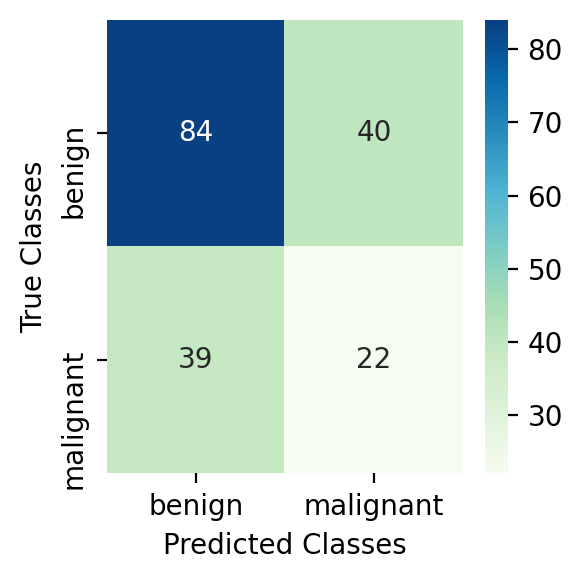

In [45]:
#predict
from tensorflow.keras.models import load_model
mymodel = load_model('CNN3L_US_roi_BC.h5')
predictions = mymodel1.predict_generator(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
# Evaluation

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys()) 
class_labels[::-1]
class_labels

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 
plt.figure(figsize=(3,3),dpi=200)
sb.heatmap(confusion_matrix(true_classes, predicted_classes),annot=True,cmap='GnBu',xticklabels=class_labels,
           yticklabels=class_labels)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.tight_layout()
plt.savefig('CM_US_CNN_roi.png')
plt.show()

In [ ]:
Image segmentation extracting features are important to correctly identify tumor type using deep learning frameworks when data set is small.
Machine learning approaches for extracted features.